In [35]:
# This is a rerun of exp4 because I don't understand how some data was created, and I need to see
# if the code I see is the code that indeed created the data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [36]:
data = pd.read_csv("./exp_0004.csv", names=["SlideName", "Dimensionality", "Start", "End", "Convergence", "SimplexSize", "Metric", "NbCalls", "Time"])
data["Metric"] = data.apply(lambda row: float(row["Metric"].replace('d','e')), axis=1)
data["SimplexSize"] = data.apply(lambda row: float(row["SimplexSize"].replace('d','e')), axis=1)
data["Time"] = data.apply(lambda row: eval(row["Time"]), axis=1)
data["MethodName"] = data.apply(lambda row: f"{row['Convergence']},size={row['SimplexSize']}", axis=1)
data["ConvergenceType"] = data.apply(lambda row: "volume" if "VOLUME" in row['Convergence'] else "tolerance", axis=1)
data["ConvergenceValue"] = data.apply(lambda row: float(row["Convergence"].split("=")[1]), axis=1)
data["Metric"].max(), data["Metric"].min()

(0.3921157200661808, -0.05182982756518695)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


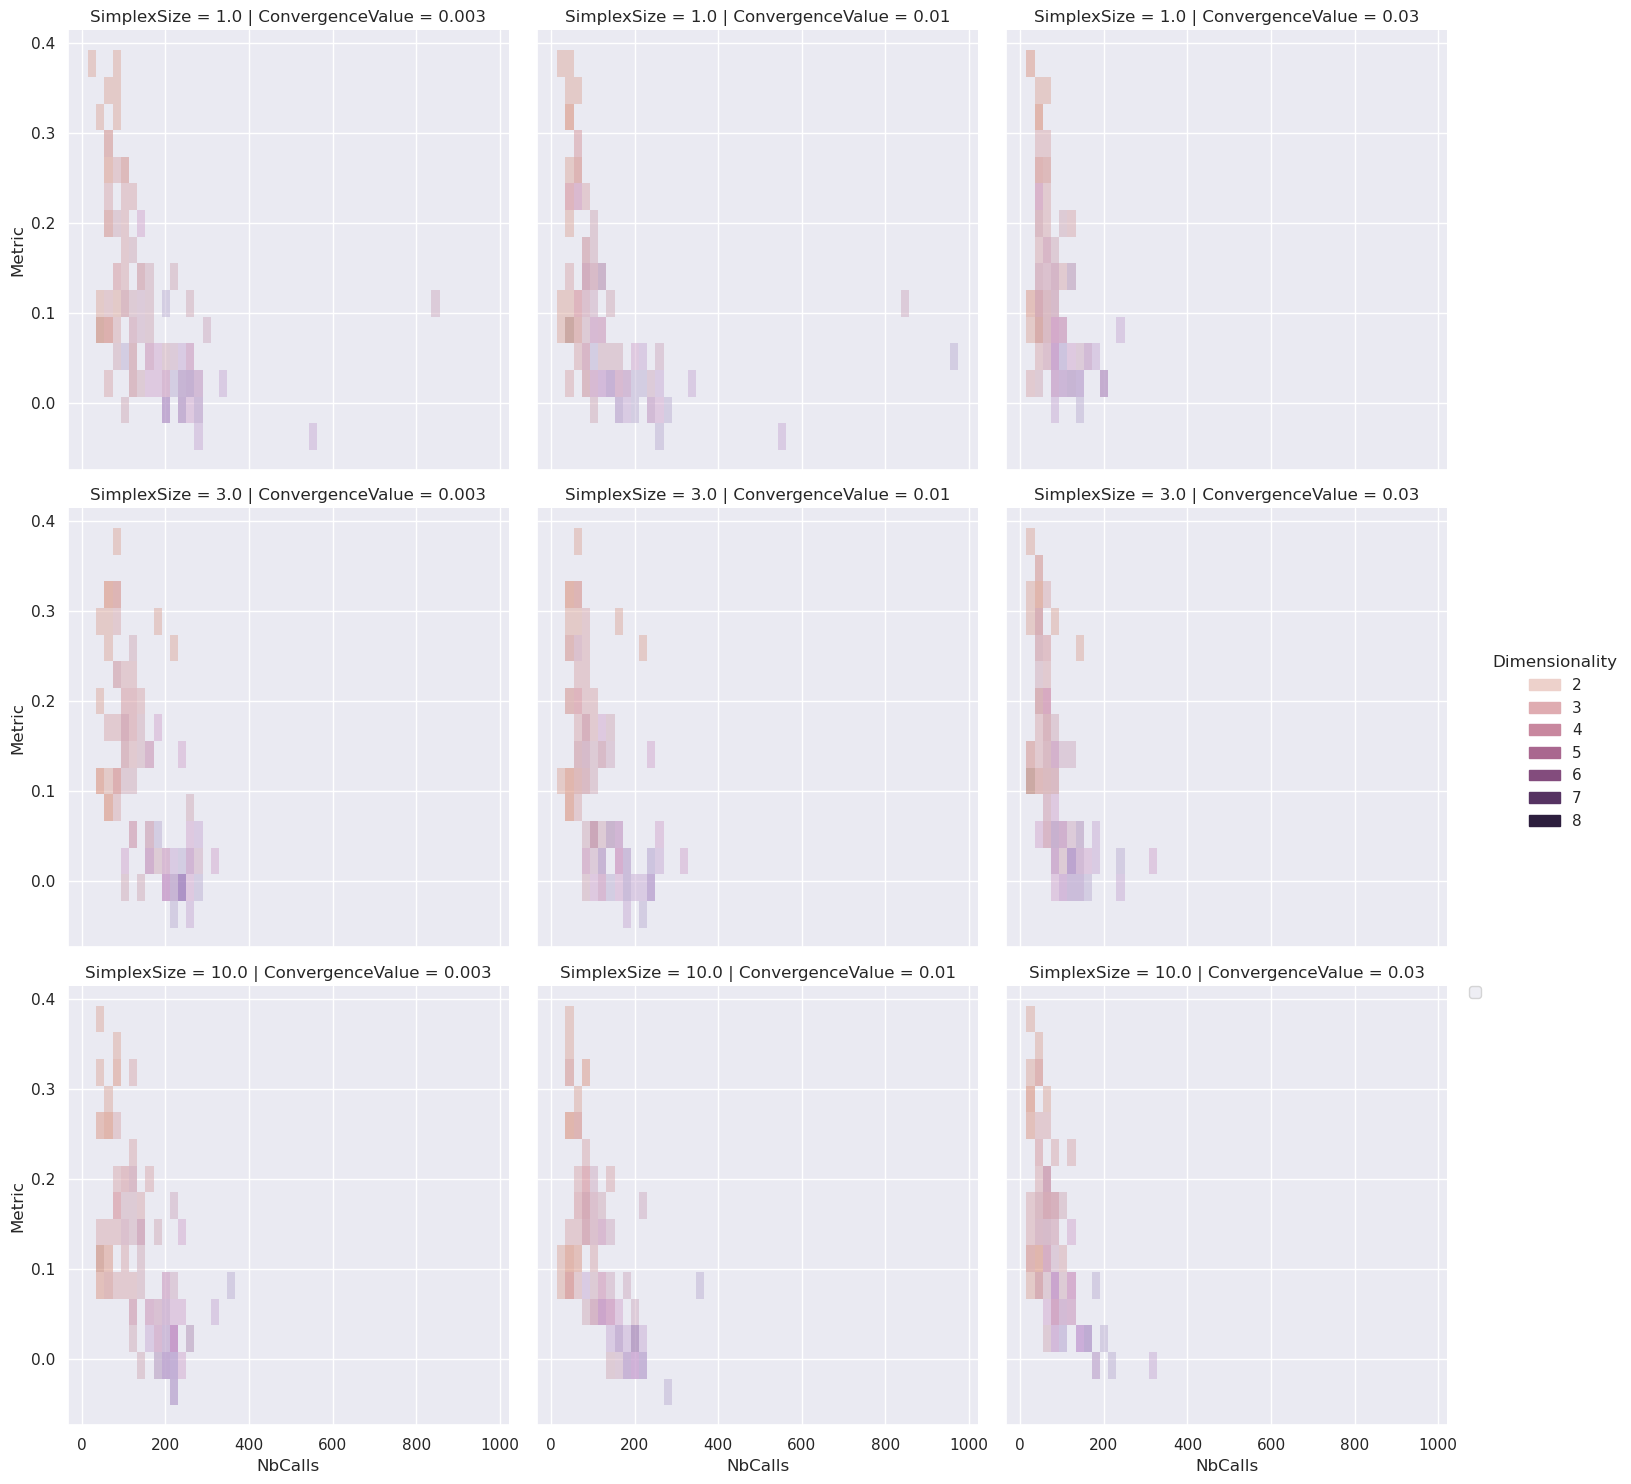

In [37]:
sns.displot(data=data.query('Dimensionality <= 10 and Metric <= 1'),
            x="NbCalls", y="Metric", kind="hist", 
            col="ConvergenceValue",  
            row="SimplexSize",# row_order=[1.,3.],
            hue="Dimensionality",
           alpha=.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Negative values are bad news, let's see what input values are causing the software to fail

In [26]:
data.sort_values(by="Metric").iloc[:3]

SlideName  Dimensionality  \
819      2D-2               2   
807      8D-1               8   
810      2D-1               2   

                                                 Start  \
819       (0.48647584331721294d0 0.1376089653200787d0)   
807  (0.26317767864276687d0 0.2680661961412216d0 0....   
810       (0.6964266551858196d0 0.29231931923722954d0)   

                                                   End   Convergence  \
819  #(0.8362172226275578d0\n                      ...  VOLUME=0.003   
807  #(0.27144198914788464d0\n                     ...   VOLUME=0.03   
810  #(0.9610638329696095d0\n                      ...  VOLUME=0.003   

     SimplexSize    Metric  NbCalls      Time             MethodName  \
819          1.0 -0.516752       39  0.010618  VOLUME=0.003,size=1.0   
807          1.0 -0.501028      203  0.121059   VOLUME=0.03,size=1.0   
810          1.0 -0.341866       50  0.014122  VOLUME=0.003,size=1.0   

    ConvergenceType  ConvergenceValue  
819          volume             0.003  
807          volume             0.030  
810          volume             0.003

So packing the 3D2 slide with the volume method should yield a wildly negative metric and let me investigate this supposed impossibility (the metric is the proportion of unused space on the slide).

Let's try to pack them with the result of the evaluation

In [27]:
for end in data.sort_values(by="Metric").iloc[:3]['End']:
    print(end)
    print()

#(0.8362172226275578d0
                                                         0.9908014985328313d0)

#(0.27144198914788464d0
                                                           0.43741827023539975d0
                                                           0.39795743976943426d0
                                                           0.4521952809227017d0
                                                           0.47862803739329046d0
                                                           0.5220487648838831d0
                                                           0.32111609983842027d0
                                                           0.5088642244758822d0)

#(0.9610638329696095d0
                                                         0.9999987448051199d0)



I unsurprisingly get "Can't pack the given items" when trying to:
```
(setf *slide* (cadr (assoc :3D-2 *slides*)))
(setf *bad-scales* #(0.9999072187124005d0
0.9995907042715872d0
0.9965184565022616d0))
(funcall (packing-objective *slide*) (coerce *bad-scales* 'vector))                                                                         
```

So why did the optimization routine return that as a valid scale vector ?

In [29]:
for start in data.sort_values(by="Metric").iloc[:3]['Start']:
    print(start)
    print()

(0.48647584331721294d0 0.1376089653200787d0)

(0.26317767864276687d0 0.2680661961412216d0 0.10822043617824639d0
         0.14482480197567438d0 0.2273841592029453d0 0.4517800285034699d0
         0.048866099838420274d0 0.10484108737541864d0)

(0.6964266551858196d0 0.29231931923722954d0)



The starting point is not packable...
```
CL-SMT-LIB> (funcall (packing-objective *slide*) (coerce  #(0.6038968023225226d0 0.047256639983786375d0 0.4702578193832041d0) 'vector))
NB CALLS 4
Error Can't pack the given items
1.7976931348623157d308
```

I had forgotten to initialize the smt solver, now it packs for the start point
```
(setf *smt* (smt-start))
(smt-new-slide *slide*)
(funcall (packing-objective *slide*) (coerce  #(0.6038968023225226d0 0.047256639983786375d0 0.4702578193832041d0) 'vector))
NB CALLS 551
0.4255648101178028d0
;; But it still does not for the bad scales
(funcall (packing-objective *slide*) (coerce *bad-scales* 'vector))
;; So why does the optimization return such a bad vector ?
;; It does not
 (cl-grnm:grnm-optimize (packing-objective *slide*)
                               (cl-grnm:initial-simplex (coerce #(0.6038968023225226d0 0.047256639983786375d0 0.4702578193832041d0) 'vector) :displace 1.0)
                               :verbose nil
                               :convergence-p (getf *convergence* :VOLUME=0.003)
                               :max-function-calls *max-iterations*)
#(0.6337265662306533d0 0.3361242246683291d0 0.47709115271653746d0)
0.2740307996450928d0
#<NM-SIMPLEX D=3 Best=  2.7403080d-001 >
119
```
I don't know what's wrong. I'll just commit everything, move the csv file aside and start again, to see if the negative values persist, because right now with the code as it is this bug is CANT REPRODUCE.
# Reproducing the bug

The bug just happened again, but the results I see in the CSV are not the results I see when I use the same value and run them in a clean smt.

Am I abusing the smt ?

I insert a break to catch an optimization gone bad in the act.

Some very small negative values are OK (e.g. -0.006, or even -.013)

When I got a very negative value (-0.2something) the smt was fucked beyond repair.

Given the comparatively light usage it's gonna get in real life, I don't care enough to correct this bug now (plus, I'm on a deadline).

# Back to the hyperparameter search

There is a clear effect of the convergence value on the number of calls

<AxesSubplot:xlabel='NbCalls', ylabel='cvs'>

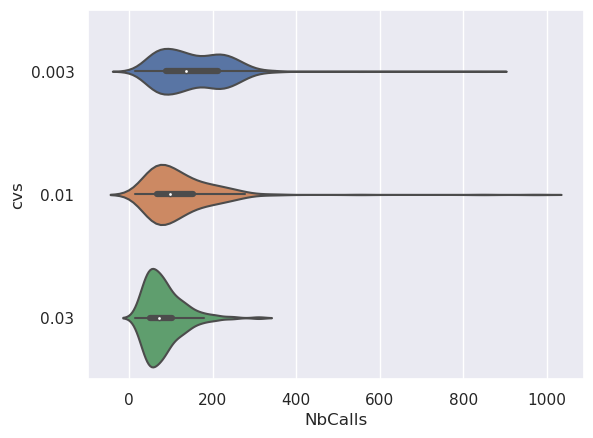

In [46]:
data_2 = data
data_2['cvs'] = data['ConvergenceValue'].apply(str)
sns.violinplot(data=data_2.query('Dimensionality <= 10 and Metric <= 1'),
            x="NbCalls",
            y="cvs",# row_order=[1.,3.],
           alpha=.5)

If it does not have an averse effect on the metric, then we are golden

<AxesSubplot:xlabel='cvs', ylabel='Metric'>

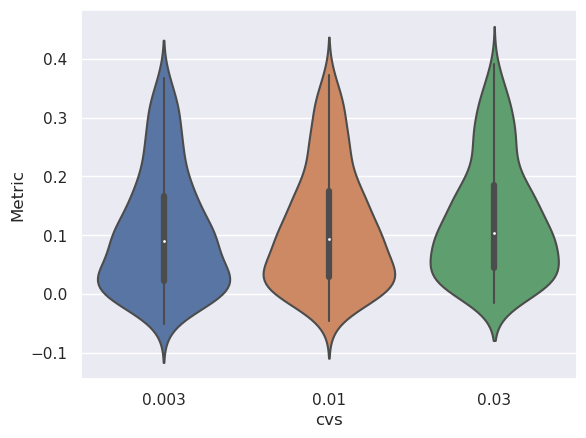

In [47]:
data_2 = data
data_2['cvs'] = data['ConvergenceValue'].apply(str)
sns.violinplot(data=data_2.query('Dimensionality <= 10 and Metric <= 1'),
            y="Metric",
            x="cvs",# row_order=[1.,3.],
           alpha=.5)

Well technically it does, but the effect on the number of calls is much more dramatic, so I'll settle with a convergence value of 0.03.

Let's look at the effect of the simplex size on both the cost and value of the solution.

<AxesSubplot:xlabel='NbCalls', ylabel='sss'>

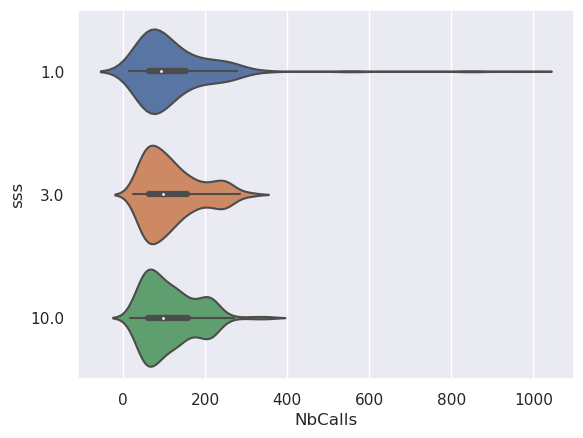

In [49]:
data_2 = data
data_2['sss'] = data['SimplexSize'].apply(str)
sns.violinplot(data=data_2.query('Dimensionality <= 10 and Metric <= 1'),
            x="NbCalls",
            y="sss",# row_order=[1.,3.],
           alpha=.5)

<AxesSubplot:xlabel='sss', ylabel='Metric'>

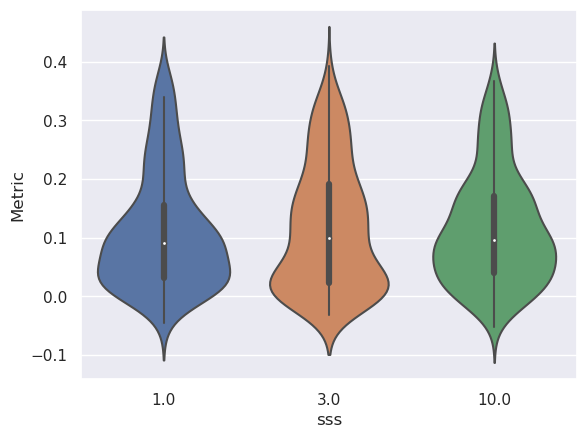

In [50]:
data_2 = data
data_2['sss'] = data['SimplexSize'].apply(str)
sns.violinplot(data=data_2.query('Dimensionality <= 10 and Metric <= 1'),
            y="Metric",
            x="sss",# row_order=[1.,3.],
           alpha=.5)

No significant difference in metric, but slightly less calls with 3 and 10, so let's go with 3.
# Conclusion

After those 4 experiments, we settle on the "volume" method, with a target volume of 0.03 and an initial simplex size of 3.

This allows us to have a single parameter to let the user get a better packing: the number of calls to smt. With a default of 1000 we should be able to get 3 to 5 different starting points and a tight packing.